In [18]:
import pandas as pd
import numpy as np
from fastai.tabular.all import *
from sklearn.feature_selection import *
from sklearn.impute import *
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.manifold import *
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from helper_functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
data = pd.read_pickle("datasets/data_EDA.pkl")

In [20]:
features_census = get_census_features()
features_non_census = get_non_census_features(data)

features_nc_keep = [
    "STATE",
    "ZIP",
    "MDMAUD",
    "DOMAIN",
    "HOMEOWNR",
    "CHILD03",
    "CHILD07",
    "CHILD12",
    "CHILD18",
    "NUMCHLD",
    "INCOME",
    "GENDER",
    "WEALTH1",
    "HIT",
    "RAMNT_4",
    "RAMNT_5",
    "RAMNT_6",
    "RAMNT_7",
    "RAMNT_8",
    "RAMNT_9",
    "RAMNT_10",
    "RAMNT_11",
    "RAMNT_12",
    "RAMNT_13",
    "RAMNT_14",
    "RAMNT_15",
    "RAMNT_16",
    "RAMNT_17",
    "RAMNT_18",
    "RAMNT_19",
    "RAMNT_20",
    "RAMNT_21",
    "RAMNT_22",
    "RAMNT_23",
    "RAMNT_24",
    "RAMNTALL",
    "NGIFTALL",
    "CARDGIFT",
    "MINRAMNT",
    "MAXRAMNT",
    "LASTGIFT",
    "AVGGIFT",
    "RFA_2R",
    "RFA_2F",
    "RFA_2A",
    "MDMAUD_R",
    "MDMAUD_F",
    "MDMAUD_A",
    "AGE",
    "RECENCY",
    "FREQUENCY",
    "AMOUNT",
]

features = features_census + features_nc_keep 

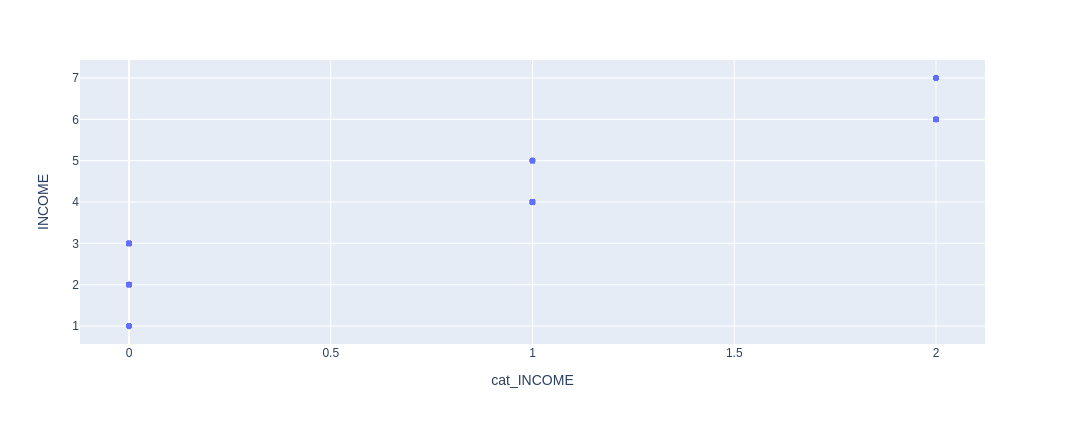

In [21]:
# FOR INCOME
dep_var = "INCOME"
new_dep_var = f"cat_{dep_var}"
data[new_dep_var] = data[dep_var]
cont_names, cat_names = cont_cat_split(data[features], max_card=2, dep_var=dep_var)
data_train = data[~data[dep_var].isnull()].copy()
data_test = data[data[dep_var].isnull()].copy().drop(columns=[dep_var, new_dep_var])
idxs_nan = data_test.index

discretizer = KBinsDiscretizer(3, encode="ordinal", strategy="kmeans")

data_train[new_dep_var] = discretizer.fit_transform(
    data_train[dep_var].to_numpy().reshape(-1, 1)
)

data[new_dep_var] = data[dep_var]
data.loc[data_train.index, new_dep_var] = data_train[new_dep_var]

data.loc[data[data[new_dep_var].isnull()].index, new_dep_var] = np.load(f"missingvalues/{dep_var}.npy")

fig = px.scatter(data_train, x=new_dep_var, y=dep_var, width=400, height=400)
fig.show()

In [22]:
#FOR DOMAIN
dep_var = "DOMAIN"
new_dep_var = f"cat_{dep_var}"

data[new_dep_var] = data[dep_var]
cont_names, cat_names = cont_cat_split(data[features], max_card=2, dep_var=dep_var)
data_train = data[~data[dep_var].isnull()].copy()
data_test = data[data[dep_var].isnull()].copy().drop(columns=[dep_var, new_dep_var])
idxs_nan = data_test.index

data[dep_var].replace({" ": np.nan}, inplace=True)
data.loc[data[data[dep_var].isnull()].index, dep_var] = np.load(f"missingvalues/{dep_var}.npy")

In [ ]:
# ONLY RUN AFTER THIS CELL IF YOU WANT TO TRAIN THE NEURAL NETWORK

In [9]:
data_train.drop(columns=[dep_var], inplace=True)

splits = RandomSplitter(valid_pct=0.1)(range_of(data_train))

to = TabularPandas(
    data_train,
    procs=[FillMissing, Categorify, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=new_dep_var,
    y_block=CategoryBlock,
    splits=splits,
    reduce_memory=True
)

dls = to.dataloaders(bs=64)

In [10]:
learn = tabular_learner(dls, layers=[256, 128], metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,1.030645,1.044699,0.690257,00:36


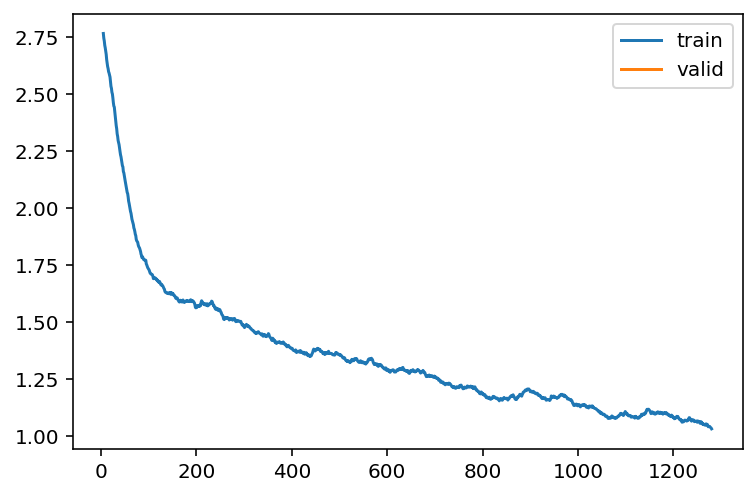

In [11]:
learn.fit_one_cycle(1, 0.01)
learn.recorder.plot_loss()

In [14]:
dl = learn.dls.test_dl(data_test)
preds = to_np(learn.get_preds(dl=dl, with_decoded=True)[-1])

In [15]:
# Create dictionary to get classes from integers to labels
dict_labels = {v: k for k, v in learn.dls.vocab.o2i.items()}

# turn integer predictions into labels
preds_labels = []
for pred in preds:
    preds_labels.append(dict_labels[pred])

In [16]:
# Save the prediction of labels
np.save(f"missingvalues/{dep_var}", np.array(preds_labels))

# Save prediction of integers
# np.save(f"missingvalues/{dep_var}", preds)

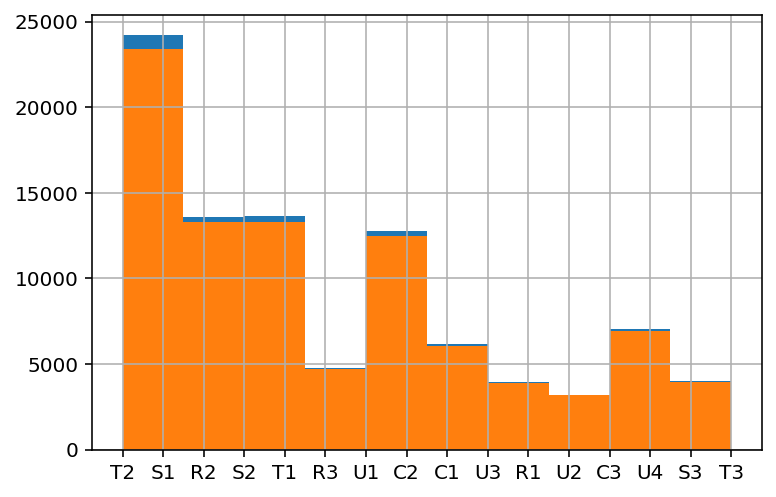

In [17]:
# FOR DOMAIN
preds = np.load(f"missingvalues/{dep_var}.npy")
data.loc[idxs_nan, new_dep_var] = preds
data[new_dep_var].hist(), data_train[new_dep_var].hist()
features.append(new_dep_var)
features.remove(dep_var)

(<AxesSubplot:>, <AxesSubplot:>)

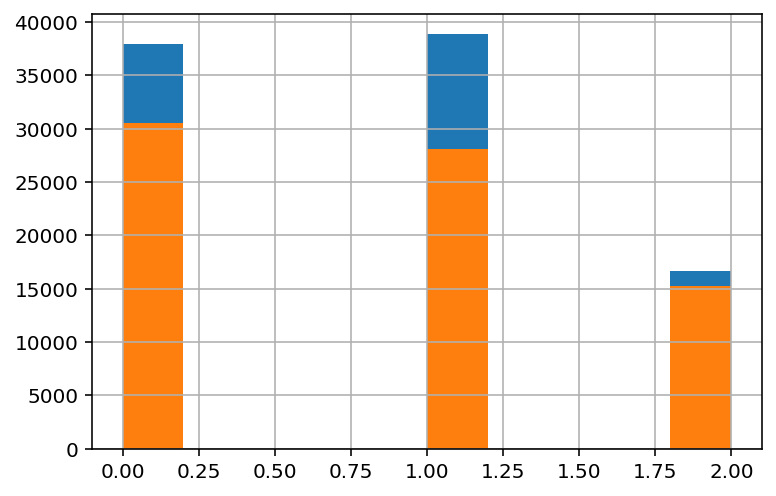

In [20]:
#KNN
data_impute[new_dep_var].hist(), data_train[new_dep_var].hist()

(<AxesSubplot:>, <AxesSubplot:>)

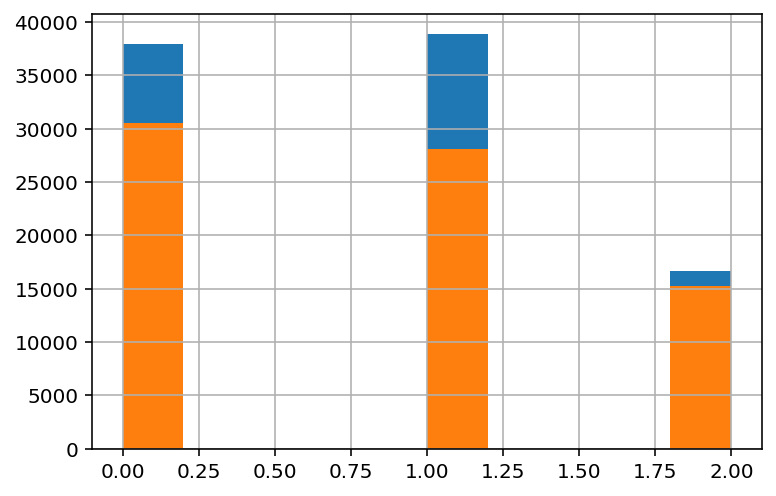

In [72]:
# SIMPLE IMPUTER
data_impute2[new_dep_var].hist(), data_train[new_dep_var].hist()

In [29]:
data["INCOME"] = data["cat_INCOME"]
data.drop(columns=["cat_DOMAIN", "cat_INCOME"], inplace=True)

In [30]:
data.to_pickle("datasets/data_NN_Imputed.pkl")

# Checkpoint

In [20]:
data = pd.read_pickle("datasets/data_NN_Imputed.pkl")

#### 'INCOME' column: imputation using 'wealth'-related columns

Now we will continue with INCOME, WEALTH1 and WEALTH2 - categorical columns, each one of them has a lot of NaNs:
    - WEALTH1 - 44,625 NaNs
    - WEALTH2 - 43,813 NaNs
    - INCOME - 21228 NaNs
We are going to impute these columns and use only INCOME column for our further analysis.

/home/fsx/anaconda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/fsx/anaconda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/fsx/anaconda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


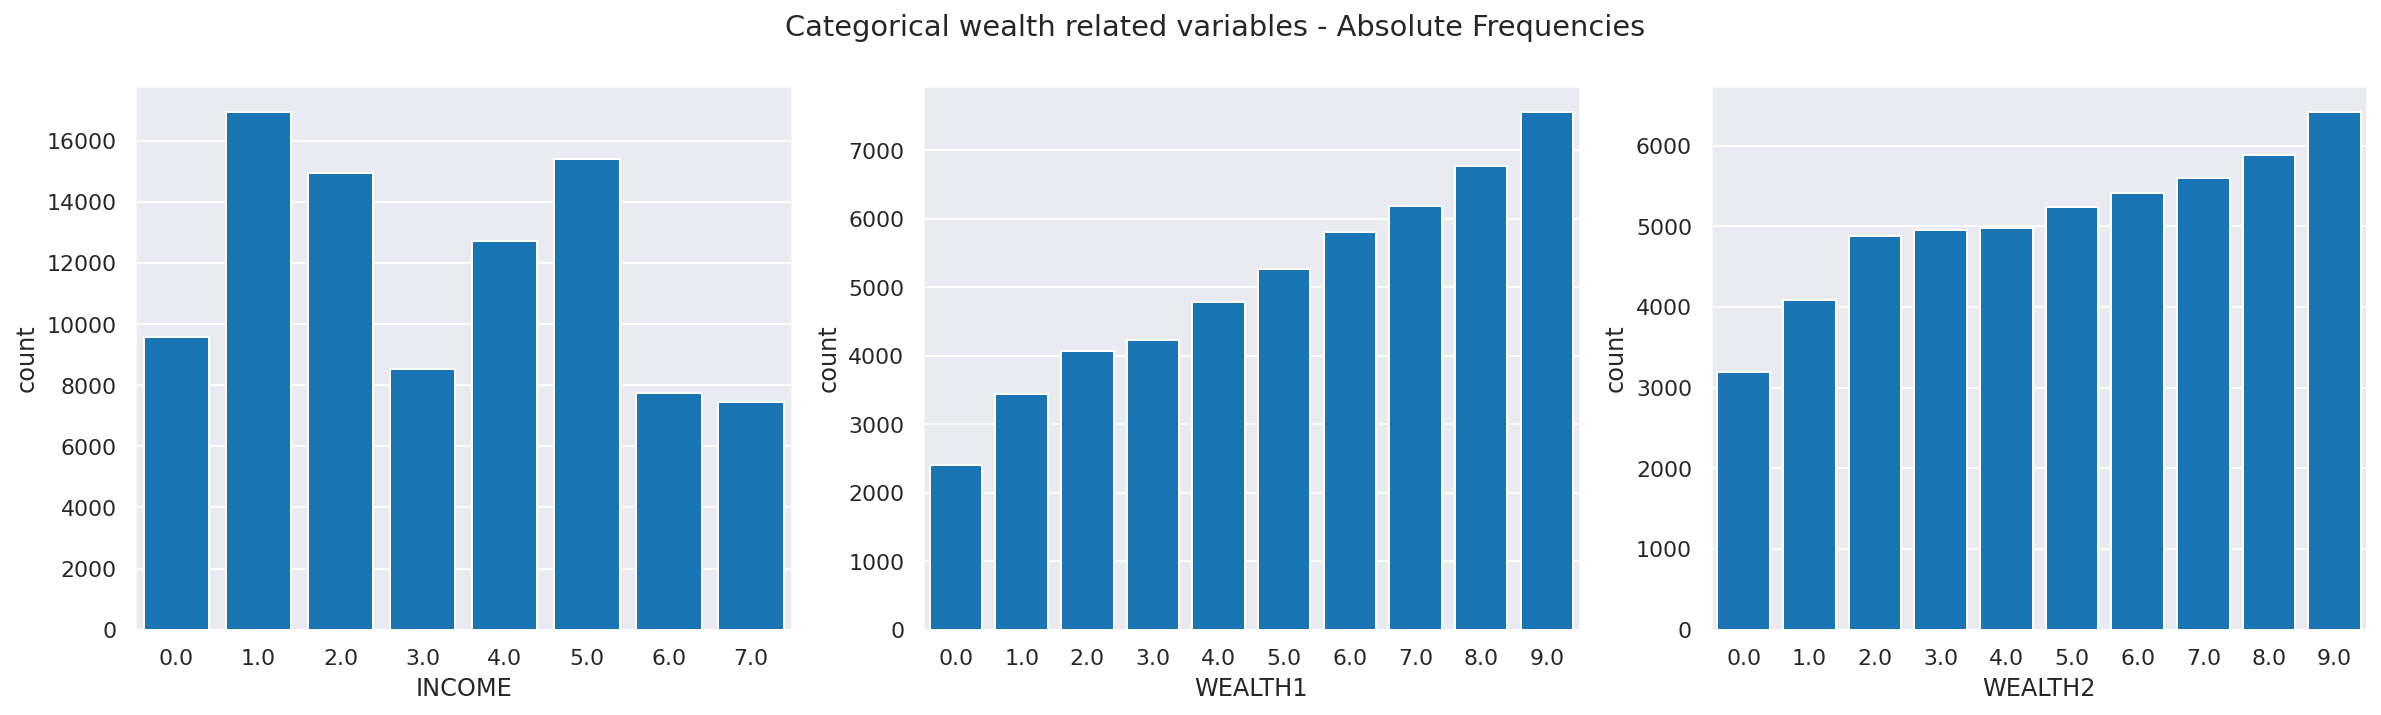

In [21]:
# Explore wealth-related categorical columns values
sns.set()

wealth_features = ['INCOME','WEALTH1','WEALTH2']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each bar plot:
for ax, feat in zip(axes.flatten(), wealth_features): 
    sns.countplot(data[feat].sort_values(), 
                  ax=ax, color='#007acc')

title = "Categorical wealth related variables - Absolute Frequencies"
plt.suptitle(title)
plt.show()

In [7]:
data = pd.read_pickle("datasets/data_NN_Imputed.pkl")
data["INCOME"] = data["cat_INCOME"]
data.drop(columns=["cat_INCOME"], inplace=True)

/home/fsx/anaconda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/fsx/anaconda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/fsx/anaconda/envs/fastai/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


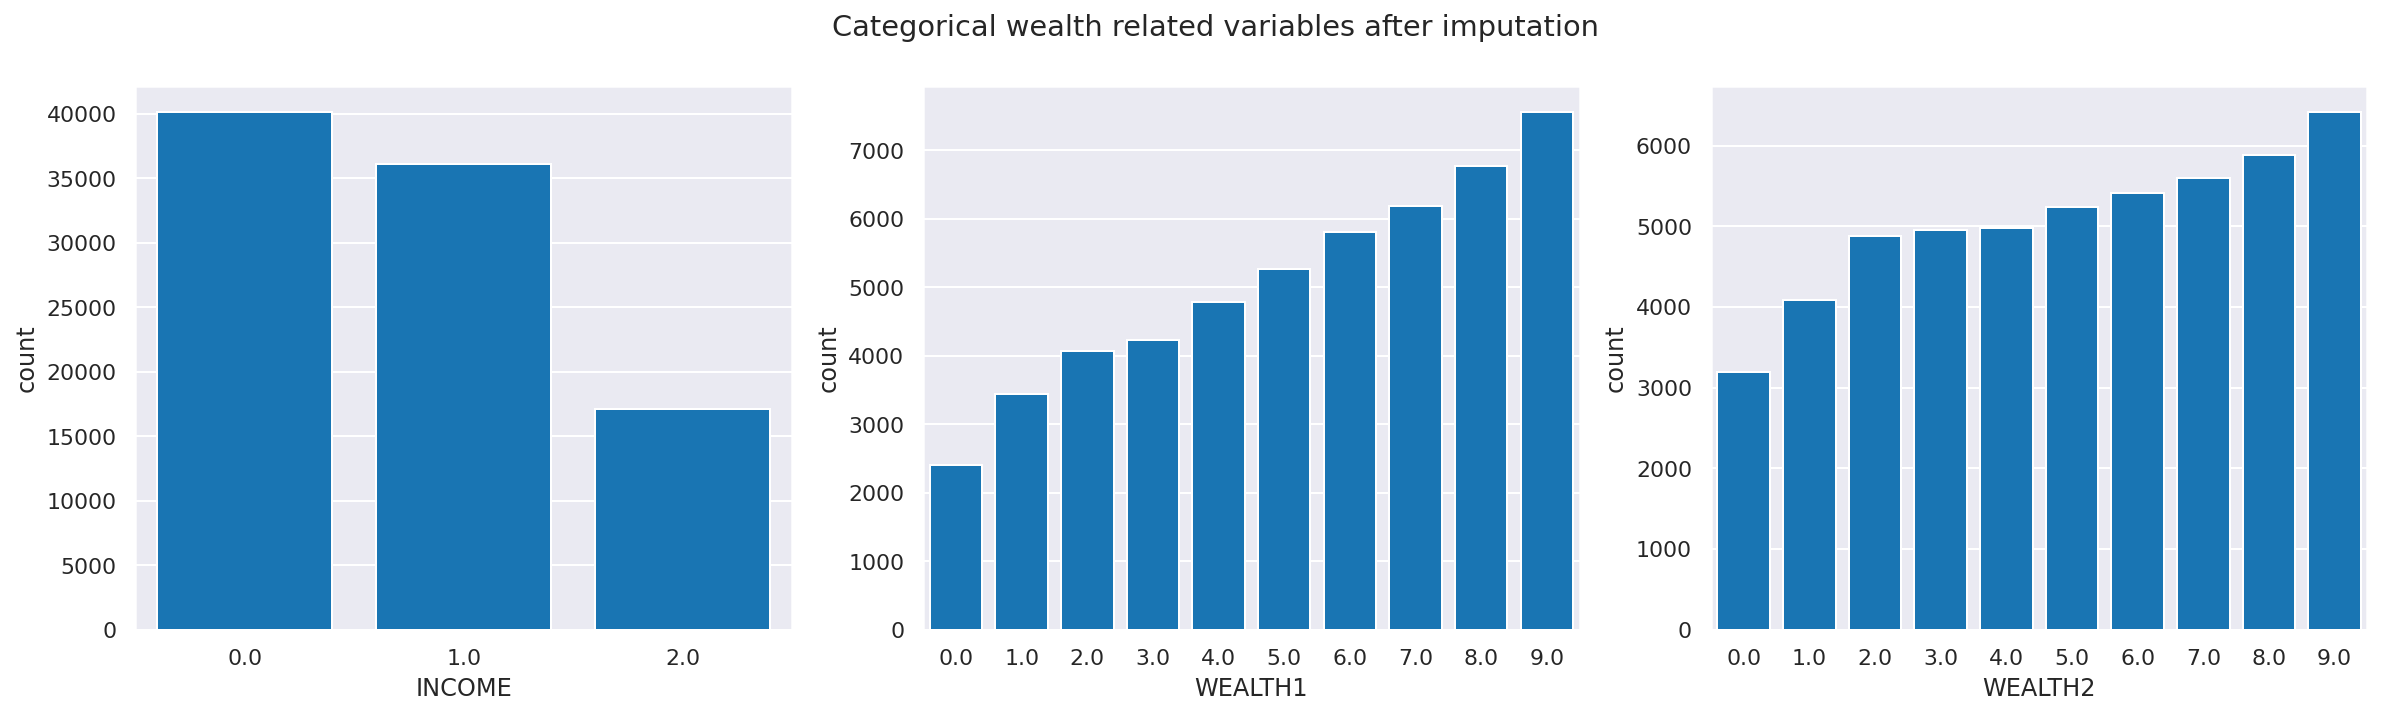

In [8]:
# Explore wealth-related categorical columns values
sns.set()

wealth_features = ['INCOME','WEALTH1','WEALTH2']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot data
# Iterate across axes objects and associate each bar plot:
for ax, feat in zip(axes.flatten(), wealth_features): 
    sns.countplot(data[feat].sort_values(), 
                  ax=ax, color='#007acc')

title = "Categorical wealth related variables after imputation"
plt.suptitle(title)
plt.show()

We have same distribution of values after imputation, as it was before imputation

#### Gender column

In [31]:
len(data.loc[(data.GENDER == "J")])

364

In [32]:
# Let's decode Gender column's values
# From metadata file M = Male, F = Female, U = Unknown, J = Joint Account, unknown gender
# not forgeting about 4 rows with values 'A', 'C'

data.loc[(data.GENDER == "M"), 'GENDER'] = '1'
data.loc[(data.GENDER == "F"), 'GENDER'] = '0'
# data.loc[(data.GENDER == "J"), 'GENDER'] = '3'

# We assume that these letters 'J','U','A','C'- Unknown values equal to NaNs
data.loc[(data.GENDER == "J") | (data.GENDER == "U")|(data.GENDER == "A")|(data.GENDER == "C"), 'GENDER'] = ' '

# Convert column to numeric
data.GENDER = pd.to_numeric(data.GENDER, errors='coerce')

In [33]:
print ('Number of NaNs in Gender:', data.GENDER.isna().sum())
data['GENDER'].value_counts()

Number of NaNs in Gender: 3257


0.0    51119
1.0    38991
Name: GENDER, dtype: int64

In [34]:
# Impute NaNs in Gender column using most frequent value
data['GENDER'] = data['GENDER'].replace(np.nan, data['GENDER'].mode()[0]).astype('int')
# data.GENDER = data.GENDER.astype('bool')


#### TCODE column exploration is added in the end of notebook

#### Domain

In [35]:
data["DOMAIN"] = pd.Categorical(data.DOMAIN)
data.DOMAIN.unique().tolist()

['T2',
 'S1',
 'R2',
 'S2',
 'T1',
 'R3',
 'U1',
 'C2',
 'C1',
 'U3',
 'R1',
 'U2',
 'C3',
 'U4',
 'S3',
 'T3']

In [36]:
data.to_pickle("datasets/data_NN_Imputed.pkl")

In [39]:
data[["DOMAIN", "INCOME"]].to_csv("missingvalues/DOMAIN_INCOME.csv")